In [1]:
import os
import time
import uuid
import cv2

In [2]:
# IMAGES_PATH = os.path.join('data','images')
# number_images = 30

In [6]:
# cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

## Do it from here

In [1]:
# import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2

In [2]:
# images_list = os.listdir("data/images/")

In [4]:
# number_images_to_view = 6
# fig, ax = plt.subplots(ncols=number_images_to_view, figsize=(20,20))
# plt.axis(False)
# for idx, image in enumerate(images_list[:number_images_to_view]):
#     img = plt.imread("data/images/"+image)
#     ax[idx].imshow(img)
# plt.show()

In [29]:
# import random
# images_list[:3]

['2f29d579-f7fe-11ed-a0b3-38d547b2c17a.jpg',
 '2f7833db-f7fe-11ed-8ccb-38d547b2c17a.jpg',
 '2fc69361-f7fe-11ed-a043-38d547b2c17a.jpg']

In [51]:
# len(images_list)*.80

64.8

In [5]:
train_images_list = os.listdir("train/images/")
valid_images_list = os.listdir("valid/images/")
test_images_list = os.listdir("test/images/")

In [83]:
# train_images_list = np.random.choice(images_list,int(len(images_list)*.80),replace=False)
# remaining_list = list(set(images_list)-set(train_images_list))
# valid_images_list = np.random.choice(remaining_list,int(len(images_list)*.15),replace=False)
# other_remaining_list = list(set(remaining_list)-set(valid_images_list))
# test_images_list = other_remaining_list

In [86]:
# folder = "train"
# for file in train_images_list:
#     existing_file_path = os.path.join("data","images",file)
#     new_file_path = os.path.join(folder,"images",file)
#     os.replace(existing_file_path,new_file_path)

In [89]:
# for folder in ['train','test','valid']:
#     for file in os.listdir(os.path.join(folder, 'images')):
#         filename = file.split('.')[0]+'.txt'
#         existing_filepath = os.path.join('data','labels', filename)
#         if os.path.exists(existing_filepath): 
#             new_filepath = os.path.join(folder,'labels',filename)
#             os.replace(existing_filepath, new_filepath)  

https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

## Working Fine !

In [33]:
import os
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Path to the directory containing train images and labels
train_dir = "train"

# List to store augmented images and their corresponding label coordinates
augmented_images = []
augmented_labels = []

# Iterate through all images in the train directory
for filename in os.listdir(os.path.join(train_dir, "images")):
    augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='yolo', 
                                                  label_fields=['class_labels']))
    if filename.endswith(".jpg"):
        # Get the image and annotation file paths
        img_file = os.path.join(train_dir, "images", filename)
        annot_file = os.path.join(train_dir, "labels", os.path.splitext(filename)[0] + ".txt")

        # Read the image
        img = plt.imread(img_file)

        # Check if annotation file exists
        if os.path.isfile(annot_file):
            with open(annot_file, 'r') as f:
                value = f.readline().strip()
                value_list = value.split()
            value_list = [float(val) for val in value_list]
            coords = value_list[1:]
        else:
            # Default label coordinates [0, 0, 0, 0] for images without annotations
            coords = [0, 0, 0, 0]

        # Augment the image and bounding box
        if coords != [0,0,0,0]:
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
            # Retrieve the augmented image and bounding box
            augmented_img = augmented['image']

            if augmented["bboxes"] != []:
 
                augmented_bbox = augmented['bboxes'][0]

                # Original image size
                original_width = img.shape[1]
                original_height = img.shape[0]

                # Augmented image size
                augmented_width = augmented_img.shape[1]
                augmented_height = augmented_img.shape[0]

                # Calculate the scale factors for width and height
                width_scale = augmented_width / original_width
                height_scale = augmented_height / original_height

                # Scale the augmented bounding box coordinates to match the augmented image size
                x_center = augmented_bbox[0] * original_width  # x-coordinate of the box center
                y_center = augmented_bbox[1] * original_height  # y-coordinate of the box center
                box_width = augmented_bbox[2] * original_width  # width of the box
                box_height = augmented_bbox[3] * original_height  # height of the box

                # Calculate the top-left and bottom-right coordinates of the box
                x_min = int((x_center - (box_width / 2)) * width_scale)
                y_min = int((y_center - (box_height / 2)) * height_scale)
                x_max = int((x_center + (box_width / 2)) * width_scale)
                y_max = int((y_center + (box_height / 2)) * height_scale)

                new_coords = [x_min, y_min, x_max, y_max]

                # Append the augmented image and its corresponding label coordinates to the list
                augmented_images.append(augmented_img)
                augmented_labels.append(new_coords)
            else:
                new_coords = [0,0,0,0]
                augmented_images.append(augmented_img)
                augmented_labels.append(new_coords)
        else:
            augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)])
            
            augmented = augmentor(image=img)

            # Retrieve the augmented image and bounding box
            augmented_img = augmented['image']
            # Append the augmented image and its corresponding label coordinates to the list
            augmented_images.append(augmented_img)
            augmented_labels.append(new_coords)

In [35]:
augmented_labels[0]

[0, 78, 190, 448]

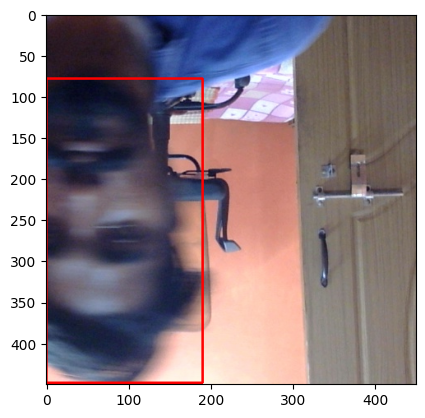

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

augmented_img = augmented_images[0]

# Calculate the top-left and bottom-right coordinates of the box
x_min = augmented_labels[0][0]
y_min = augmented_labels[0][1]
x_max = augmented_labels[0][2]
y_max = augmented_labels[0][3]


# Draw the rectangle on the augmented image
color = (255, 0, 0)  # Blue color
thickness = 2  # Thickness of the rectangle border
cv2.rectangle(augmented_img, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the augmented image with the rectangle
plt.imshow(augmented_img)
plt.show()

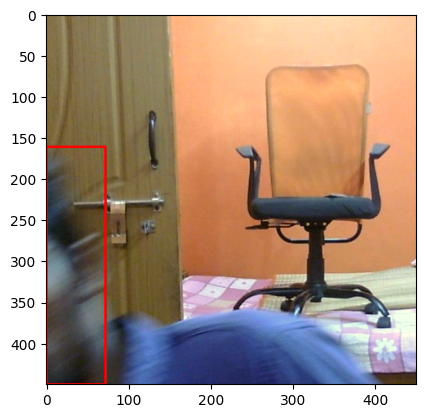

In [13]:
loc_img = "train/images/314ceb65-f7fe-11ed-89d9-38d547b2c17a.jpg"
loc_annot = "train/labels/314ceb65-f7fe-11ed-89d9-38d547b2c17a.txt"
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread(loc_img)
with open(loc_annot,'r') as f:
    value = f.readline().strip()
    value_list = value.split()
value_list = [float(val)for val in value_list]

coords = value_list[1:]

augmented = augmentor(image=img,bboxes=[coords],class_labels=['face'])

# Assuming augmented['image'] is the augmented image you want to draw on
augmented_img =augmented['image']

# Assuming augmented['bboxes'][0] contains the augmented bounding box coordinates
augmented_bbox = augmented['bboxes'][0]

# Original image size
original_width = 640
original_height = 480

# Augmented image size
augmented_width = 450
augmented_height = 450

# Calculate the scale factors for width and height
width_scale = augmented_width / original_width
height_scale = augmented_height / original_height

# Scale the augmented bounding box coordinates to match the augmented image size
x_center = augmented_bbox[0] * original_width  # x-coordinate of the box center
y_center = augmented_bbox[1] * original_height  # y-coordinate of the box center
box_width = augmented_bbox[2] * original_width  # width of the box
box_height = augmented_bbox[3] * original_height  # height of the box

# Calculate the top-left and bottom-right coordinates of the box
x_min = int((x_center - (box_width / 2)) * width_scale)
y_min = int((y_center - (box_height / 2)) * height_scale)
x_max = int((x_center + (box_width / 2)) * width_scale)
y_max = int((y_center + (box_height / 2)) * height_scale)

new_coords = [x_min,y_min,x_max,y_max]

# Draw the rectangle on the augmented image
color = (255, 0, 0)  # Blue color
thickness = 2  # Thickness of the rectangle border
cv2.rectangle(augmented_img, (x_min, y_min), (x_max, y_max), color, thickness)

# Display the augmented image with the rectangle
plt.imshow(augmented_img)
plt.show()